In [70]:
# Import all packages
import cv2
import time
import pickle
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.python.framework import ops
from tqdm import tqdm

train_graph = tf.Graph()

In [2]:
IMAGE_FOLDER = "driving_dataset/"
DATA_FILE = "driving_dataset/data.txt"
CHECKPOINT = "./train_model.ckpt"

In [3]:
f = open(DATA_FILE, 'r')
info = []
for line in f:
    info.append(line.split())

In [4]:
data = pd.DataFrame(info, columns=['image_name','steering_angle'])

data.head()

,image_name,steering_angle
0,0.jpg,0.000000
1,1.jpg,0.000000
2,2.jpg,0.000000
3,3.jpg,0.000000
4,4.jpg,0.000000


In [49]:
images = []
labels = []

for index, row in tqdm(data.iterrows()):
    image = cv2.imread(IMAGE_FOLDER + row['image_name'])
    resized_image = cv2.resize(image[-150:], (200,66))
    images.append(resized_image)
    labels.append(float(row['steering_angle']) * scipy.pi / 180)

45406it [02:17, 330.92it/s]


In [50]:
# Convert the images and labels into numpy array
images = np.array(images).astype('float32') / 255.0
labels = np.array(labels).astype('float32')

print("Images shape: " + str(images.shape))
print("Labels shape: " + str(labels.shape))

Images shape: (45406, 66, 200, 3)
Labels shape: (45406,)


In [65]:
# Shuffle the train images and split into trian and test data
images, labels = shuffle(images, labels)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, random_state=0, test_size=0.2)
print("Number of Training examples: " + str(train_images.shape[0]))
print("Number of Testing examples: " + str(test_images.shape[0]))

# Reshape the images along with the number of channels
print("train_images shape: " + str(train_images.shape))
print("test_images shape: " + str(test_images.shape))

# Reshape the labels too
train_labels = train_labels.reshape(train_labels.shape[0], 1)
test_labels = test_labels.reshape(test_labels.shape[0], 1)
print("train_labels shape: " + str(train_labels.shape))
print("test_labels shape: " + str(test_labels.shape))

Number of Training examples: 36324
Number of Testing examples: 9082
train_images shape: (36324, 66, 200, 3)
test_images shape: (9082, 66, 200, 3)
train_labels shape: (36324, 1)
test_labels shape: (9082, 1)


In [71]:
m = train_images.shape[0] # Number of training examples
n_H = train_images.shape[1] # Images' height
n_W = train_images.shape[2] # Images' width
n_C = train_images.shape[3] # number of channels
n_cls = train_labels.shape[1] # number of classes

# Create placeholders for the train data and label
with train_graph.as_default():
    X = tf.placeholder(tf.float32, [None, n_H, n_W, n_C], name = 'input')
    Y = tf.placeholder(tf.float32, [None, n_cls], name = 'output')
    keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')

In [72]:
# Initialize the weights for the convolution layers
# shape = [filter_size, filter_size, num_input_channels, num_filters]
with train_graph.as_default():
    W1 = tf.get_variable("W1", [5, 5, 3, 24], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [5, 5, 24, 36], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3", [5, 5, 36, 48], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W4 = tf.get_variable("W4", [3, 3, 48, 64], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W5 = tf.get_variable("W5", [3, 3, 64, 64], initializer = tf.contrib.layers.xavier_initializer(seed=0))

In [73]:
with train_graph.as_default():
    # Layer1 - Convolutional
    conv_layer1 = tf.nn.conv2d(X, W1, strides=[1, 2, 2, 1], padding='SAME', name = 'conv1')
    relu_layer1 = tf.nn.relu(conv_layer1, name = 'relu1')
    
    # Layer2 - Convolutional
    conv_layer2 = tf.nn.conv2d(relu_layer1, W2, strides=[1, 2, 2, 1], padding='SAME', name = 'conv2')
    relu_layer2 = tf.nn.relu(conv_layer2, name = 'relu2')

    # Layer3 - Convolutional
    conv_layer3 = tf.nn.conv2d(relu_layer2, W3, strides=[1, 2, 2, 1], padding='SAME', name = 'conv3')
    relu_layer3 = tf.nn.relu(conv_layer3, name = 'relu3')

     # Layer4 - Convolutional
    conv_layer4 = tf.nn.conv2d(relu_layer3, W4, strides=[1, 1, 1, 1], padding='SAME', name = 'conv4')
    relu_layer4 = tf.nn.relu(conv_layer4, name = 'relu4')

     # Layer5 - Convolutional
    conv_layer5 = tf.nn.conv2d(relu_layer4, W5, strides=[1, 1, 1, 1], padding='SAME', name = 'conv5')
    relu_layer5 = tf.nn.relu(conv_layer5, name = 'relu5')
    
    # Layer6 - Fully_Connected (Don't forget to flatten the previous layer and then apply dropout)
    flatten_layer6 = tf.contrib.layers.flatten(relu_layer5)
    fc_layer6 = tf.contrib.layers.fully_connected(flatten_layer6, 1164, activation_fn=tf.nn.relu, scope = 'fc1')
    dropout6 = tf.nn.dropout(fc_layer6, keep_prob, name = 'dropout1')

    # Layer7 - Fully_Connected
    fc_layer7 = tf.contrib.layers.fully_connected(dropout6, 100, activation_fn=tf.nn.relu, scope = 'fc2')
    dropout7 = tf.nn.dropout(fc_layer6, keep_prob, name = 'dropout2')

    # Layer8 - Fully_Connected
    fc_layer8 = tf.contrib.layers.fully_connected(dropout7, 50, activation_fn=tf.nn.relu, scope = 'fc3')
    dropout8 = tf.nn.dropout(fc_layer6, keep_prob, name = 'dropout3')

    # Layer9 - Fully_Connected
    fc_layer9 = tf.contrib.layers.fully_connected(dropout8, 10, activation_fn=tf.nn.relu, scope = 'fc4')
    dropout9 = tf.nn.dropout(fc_layer6, keep_prob, name = 'dropout4')

    # Layer10 - Fully_Connected
    fc_layer10 = tf.contrib.layers.fully_connected(dropout9, n_cls, activation_fn=None, scope = 'fc5')
    print(fc_layer10)

Tensor("fc5/BiasAdd:0", shape=(?, 1), dtype=float32)


In [75]:
# Use mean square error cost function
with train_graph.as_default():
    # Use mean squared error as the cost function
    cost = tf.losses.mean_squared_error(labels = Y, predictions = fc_layer10)

    # Use adam optimizer
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

In [76]:
# Funcion: To pick random minibatches to train the model
def random_mini_batches(train, labels, batch_size, seed):
    # Always change the seed so that we randomize in different order
    np.random.seed(seed)
    # Make sure we shuffle both the train data and the label in the same order
    p = np.random.permutation(len(train))
    train = train[p]
    labels = labels[p]
    train_batches = []
    label_batches = []
    # Dividing the train data into minibatches
    for batch_i in range(0, len(train)//batch_size):
        start_i = batch_i * batch_size
        train_batch = train[start_i:start_i + batch_size]
        label_batch = labels[start_i:start_i + batch_size]
        train_batches.append(train_batch)
        label_batches.append(label_batch)
            
    return train_batches, label_batches 

Epoch 0 completed : Time usage 5 minutes
	- Cost after epoch 0: 0.222453
Epoch 1 completed : Time usage 4 minutes
	- Cost after epoch 1: 0.120065
Epoch 2 completed : Time usage 4 minutes
	- Cost after epoch 2: 0.054746
Epoch 3 completed : Time usage 4 minutes
	- Cost after epoch 3: 0.034553
Epoch 4 completed : Time usage 5 minutes
	- Cost after epoch 4: 0.023372
Epoch 5 completed : Time usage 6 minutes
	- Cost after epoch 5: 0.016400
Epoch 6 completed : Time usage 5 minutes
	- Cost after epoch 6: 0.015865
Epoch 7 completed : Time usage 5 minutes
	- Cost after epoch 7: 0.015050
Epoch 8 completed : Time usage 4 minutes
	- Cost after epoch 8: 0.014369
Epoch 9 completed : Time usage 5 minutes
	- Cost after epoch 9: 0.011876
Epoch 10 completed : Time usage 5 minutes
	- Cost after epoch 10: 0.010279
Epoch 11 completed : Time usage 6 minutes
	- Cost after epoch 11: 0.010778
Epoch 12 completed : Time usage 5 minutes
	- Cost after epoch 12: 0.010065
Epoch 13 completed : Time usage 5 minutes
	- 

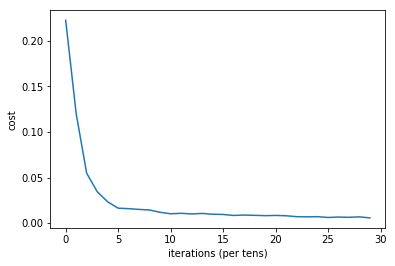

Test MSE: 0.2985


In [77]:
ops.reset_default_graph()
tf.set_random_seed(1)

# Initialize all the hyperparameters
seed = 3
num_epochs = 30
minibatch_size = 100
costs = [] 

# Training the model
with tf.Session(graph=train_graph) as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    # loader = tf.train.import_meta_graph("./" + CHECKPOINT + '.meta')
    # loader.restore(sess, CHECKPOINT)
    
    # Loop over number of epochs
    for epoch in range(num_epochs):
        
        start_time = time.time()
        minibatch_cost = 0
        num_minibatches = int(m / minibatch_size)
        seed = seed + 1
        # Calling the random_mini_batches function to get the batches
        train_batches, label_batches = random_mini_batches(train_images, train_labels, minibatch_size, seed)
        
        # Now train the model for each of that batches and calculate the minibatch cost
        for batch_i in range(num_minibatches):
            
            # Choose the minibatches
            minibatch_X = train_batches[batch_i]
            minibatch_Y = label_batches[batch_i]
            
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob: 0.8})
            
            minibatch_cost += temp_cost / num_minibatches
            
        # Print the cost for every epoch
        print("Epoch " + str(epoch) + " completed : Time usage " + str(int((time.time()-start_time)/60)) + " minutes")
        print("\t- Cost after epoch %i: %f" % (epoch, minibatch_cost))
        
        # Don't forget to save the model
        saver = tf.train.Saver() 
        saver.save(sess, CHECKPOINT)
        costs.append(minibatch_cost)
            
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.show()
    
    # Calculate MSE for the testing data
    test_pred = sess.run(fc_layer6, feed_dict={X: test_images, keep_prob: 1.0})
    test_mse = tf.reduce_mean(tf.square(test_pred - test_labels))
    print("Test MSE: %.4f" % sess.run(test_mse))